<div align="center" style="color:powderblue; background-color:#2e2e2e; padding:20px; border-radius:10px;">

# Aprendizaje Profundo

### Grado en Ciencia de Datos

**Universidad Internacional de la Rioja (UNIR)**  
**Profesor:** Xuan González  
**Curso:** 2024-2025


**Tema 5: Entrenamiento de redes neuronales profundas**

**Modificaciones del descenso del gradiente**

---

</div>

# Descenso de gradiente y sus modificaciones

En este cuaderno vamos a comparar la convergencia del entrenamiento de una DNN sencilla para clasificación usando el descenso del gradiente de diferentes maneras: con toda la muestra, con cada individuo y con pequeños lotes de datos.

### Dataset

Comencemos cargando el dataset iris, que ya conocemos.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Cargar el dataset Iris
iris = load_iris()
X = iris.data
y = iris.target

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

### Definición del modelo

In [2]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = SimpleNN(input_size=4, hidden_size=10, num_classes=3)

### Función de pérdida

Usaremos cross-entropy para clasificación multicategoría.

In [3]:
criterion = nn.CrossEntropyLoss()

### Entrenamiento

Vamos a comparar diferentes maneras de hacer el descenso del gradiente.

1. Descenso del gradiente clásico, aplicado sobre todo el dataset de datos (batch gradient descend, BGD). En general, este método fluctúa menos pero tarda más en converger. Sobre todo, es computacionalmente más costoso e inviable en datasets grandes.

2. Descenso del gradiente estocástico (SGD). En este método, el modelo se actualiza utilizando muestras de un solo individuo. Se seleccionan muestras aleatorias o bien se utiliza el 100% de datos de la muestra. Es lento y fluctuante, pero converge relativamente rápido. Es más sensible a la tasa de aprendizaje que el BGD.

3. Descenso del gradiente estocástico con mini-lotes de datos (mini-batch SGD). Es hacer un SGD pero con lotes de un número arbitrario de datos (por ejemplo, 16). Es un compromiso entre los dos métodos anteriores y suele ser el más usado.

In [11]:
### BGD
optimizer_bgd = torch.optim.SGD(model.parameters(), lr=0.01)
# Loader con todo el conjunto de entrenamiento como un solo batch
train_loader_bgd = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=len(X_train_tensor))

# SGD
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.01)
# Loader con batch_size=1
train_loader_sgd = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=1, shuffle=True)


# mini-batch SGD
optimizer_sgd_mb = torch.optim.SGD(model.parameters(), lr=0.01)
# Loader con batch_size=16
train_loader_mb = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

### Función de entrenamiento

In [5]:
def train_model(model, criterion, optimizer, train_loader, epochs):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Reiniciar gradientes
            optimizer.zero_grad()
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # Calcular pérdida promedio
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
    return loss_history

### Entrenamos los modelos

In [6]:
import time
model_bgd = SimpleNN(4, 10, 3)
optimizer_bgd = torch.optim.SGD(model_bgd.parameters(), lr=0.01)
t0 = time.time()
loss_history_bgd = train_model(model_bgd, criterion, optimizer_bgd, train_loader_bgd, epochs=100)
t_bgd = time.time() - t0

model_sgd = SimpleNN(4, 10, 3)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01)
t0 = time.time()
loss_history_sgd = train_model(model_sgd, criterion, optimizer_sgd, train_loader_sgd, epochs=100)
t_sgd = time.time() - t0

model_mb = SimpleNN(4, 10, 3)
optimizer_mb = torch.optim.SGD(model_mb.parameters(), lr=0.01)
t0 = time.time()
loss_history_mb = train_model(model_mb, criterion, optimizer_mb, train_loader_mb, epochs=100)
t_mb = time.time() - t0

## Comparación de resultados

In [7]:
# Vamos a ver cuánto ha tardado cada uno
print(f"BGD: {t_bgd:.3f} s")
print(f"SGD: {t_sgd:.3f} s")
print(f"Mini-batch SGD: {t_mb:.3f} s")

BGD: 0.187 s
SGD: 3.438 s
Mini-batch SGD: 0.339 s


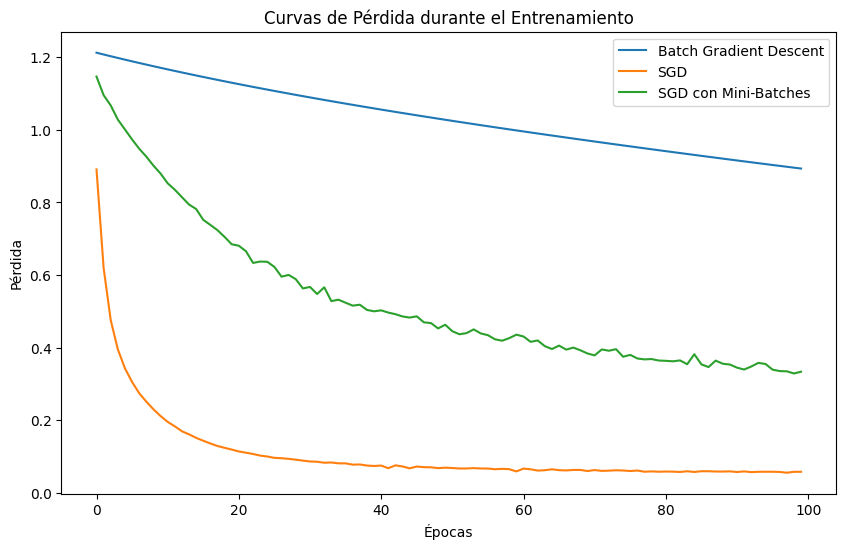

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history_bgd, label='Batch Gradient Descent')
plt.plot(loss_history_sgd, label='SGD')
plt.plot(loss_history_mb, label='SGD con Mini-Batches')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curvas de Pérdida durante el Entrenamiento')
plt.legend()
plt.show()

### Conclusiones

Efectivamente vemos que la convergencia es mayor para SGD y menos para BDG. El tiempo de entrenamiento es mucho mayor para SGD, mientras que el compromiso entre tiempo de entrenamiento y velocidad de convergencia es óptimo para el SGD con mini-batches.

# Introducción al Momentum de Nesterov
 
El **Momentum de Nesterov** es una técnica de optimización que mejora la convergencia durante el entrenamiento de modelos de aprendizaje profundo. Es una variante del método de momentum estándar que proporciona una mejor anticipación de la dirección de descenso, lo que puede resultar en una convergencia más rápida y estable.
 
### Fundamentos Teóricos

#### Momentum Estándar:
El método de momentum clásico actualiza los parámetros de la siguiente manera:

$$
v_t = \gamma v_{t-1} + \eta \nabla J(\theta_{t-1})
$$

$$
\theta_t = \theta_{t-1} - v_t
$$

Donde:
- $v_t$ es la velocidad o el término de momentum.
- $\gamma$ es el coeficiente de momentum (0 < $\gamma$ < 1).
- $\eta$ es la tasa de aprendizaje.
- $\nabla J(\theta_{t-1})$ es el gradiente de la función de pérdida respecto a los parámetros $\theta$ (a veces llamo a la función de pérdida $L$).
 
#### Momentum de Nesterov:
El Momentum de Nesterov modifica el método estándar evaluando el gradiente no en la posición actual, sino en una posición adelantada:

$$
v_t = \gamma v_{t-1} + \eta \nabla J(\theta_{t-1} - \gamma v_{t-1})
$$
 
$$
\theta_t = \theta_{t-1} - v_t
$$
 
La diferencia clave es que el gradiente se calcula en $\theta_{t-1} - \gamma v_{t-1}$, anticipando hacia dónde se moverán los parámetros, lo que puede proporcionar una corrección más precisa.

La idea es que al anticipar el próximo paso, podemos ajustar el movimiento actual para corregir cualquier desviación, permitiendo una convergencia más eficiente especialmente en regiones con superficies de error complicadas.


### Entrenamos el modelo con y sin momento de nesterov

In [9]:
# Preparar el DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Entrenar el modelo con SGD sin Momentum
model_sgd = SimpleNN(4, 10, 3)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01)
loss_history_sgd = train_model(model_sgd, criterion, optimizer_sgd, train_loader, epochs=100)

# Entrenar con momento clásico
model_momentum = SimpleNN(4, 10, 3)
optimizer_momentum = torch.optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.9)
loss_history_momentum = train_model(model_momentum, criterion, optimizer_momentum, train_loader, epochs=100)

# Entrenar el modelo con Momentum de Nesterov
model_nesterov = SimpleNN(4, 10, 3)
optimizer_nesterov = torch.optim.SGD(model_nesterov.parameters(), lr=0.01, momentum=0.9, nesterov=True)
loss_history_nesterov = train_model(model_nesterov, criterion, optimizer_nesterov, train_loader, epochs=100)

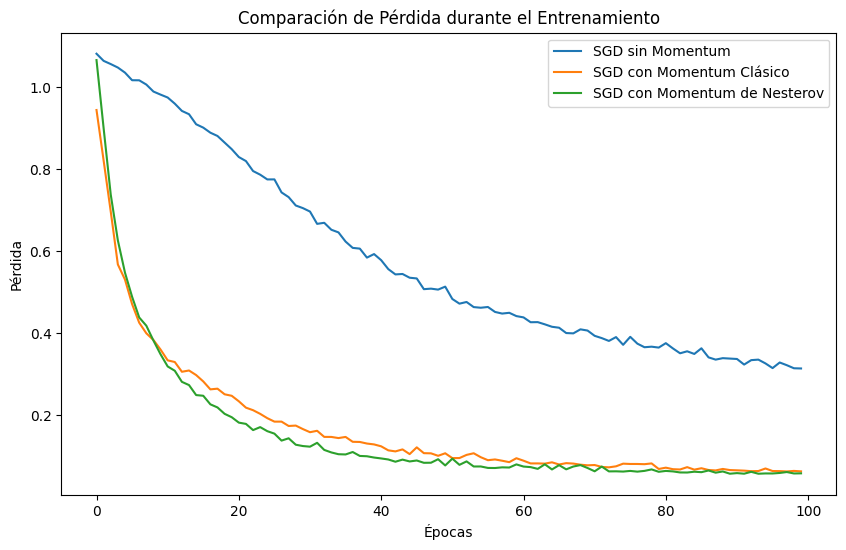

In [10]:
# Graficar las curvas de pérdida
plt.figure(figsize=(10, 6))
plt.plot(loss_history_sgd, label='SGD sin Momentum')
plt.plot(loss_history_momentum, label='SGD con Momentum Clásico')
plt.plot(loss_history_nesterov, label='SGD con Momentum de Nesterov')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Comparación de Pérdida durante el Entrenamiento')
plt.legend()
plt.show()

### Conclusiones

Se puede apreciar cómo el momentum mejora la convergencia y, en este ejemplo, el momentum de Nesterov funciona mejor que el clásico.